# Explore Data

Project : Predicting Monthly Electricity Consumption 

In [68]:
# import the library
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold

from IPython.display import display
import matplotlib.dates as mdates
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [3]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'
mfolder = 'E:/Users/Fern/energy_data/'

In [64]:
combine = pd.read_csv(cleanfolder+'combine.csv').dropna()
combine['Year-Month'] = pd.to_datetime(combine['Year-Month'])
combine = combine.set_index('Year-Month')
# set State and Regions columns as category 
combine['State'] = combine['State'].astype('category')
combine['Regions'] = combine['Regions'].astype('category')

In [44]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Sale_ALL_no_OTH'],
      dtype='object')

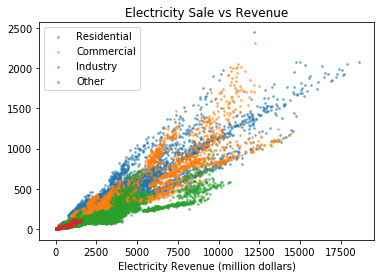

In [39]:
sale_cols = ['Sale_RES', 'Sale_COM', 'Sale_IND','Sale_OTH']
rev_cols = ['Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH']

for sale_col, rev_col in zip(sale_cols,rev_cols):
    plt.scatter(x=raw[sale_col],y=raw[rev_col],label=sale_col[-4:],alpha=0.5,s=3)

plt.title('Electricity Sale vs Revenue')
plt.xlabel('Electricity Sale (million kilowatthours)')
plt.xlabel('Electricity Revenue (million dollars)')
plt.legend(['Residential','Commercial','Industry','Other'])


Since revenue follow a linear relationship with consumption with slope as retail price. Being able to predict the consumption also means predicting the revenue.  

In [40]:
# drop revenue columns from the feature 
raw = raw.drop(rev_cols,axis=1)

In [41]:
# distribution among each sector
percent = raw[sale_cols].sum(axis=0)
percent = percent/percent.sum()

Text(0.5, 1.0, 'Electricity Consumption in Each Sector')

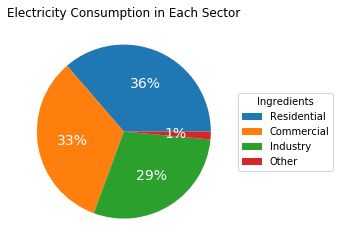

In [42]:
plt.pie(percent,autopct= '%.0f%%', textprops=dict(size='14',color="w"))
plt.legend( ['Residential','Commercial','Industry','Other'],
          title="Ingredients",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Electricity Consumption in Each Sector')

In [59]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Sale_ALL_no_OTH'],
      dtype='object')

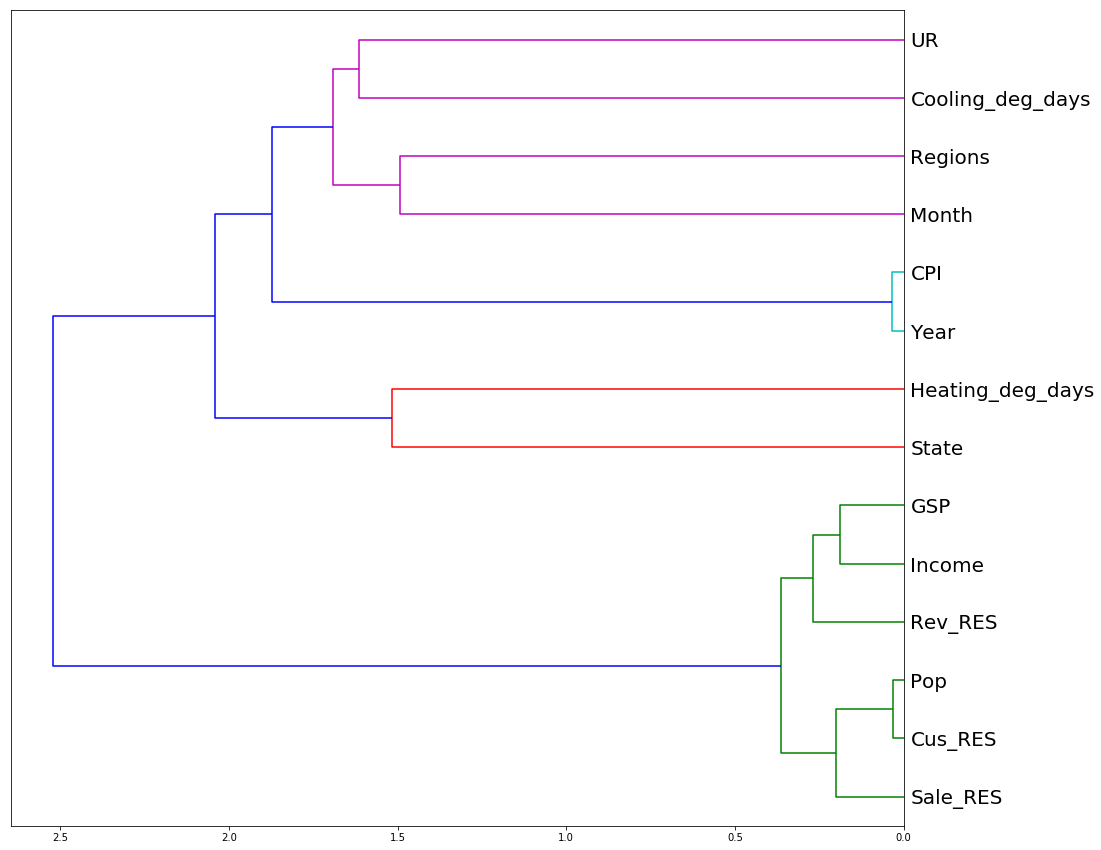

In [53]:
df = combine[['Year', 'Month', 'State', 'Sale_RES','Rev_RES','Cus_RES',
              'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP','CPI', 'Regions']]

from scipy.cluster import hierarchy as hc

# Redundant Features
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(16,15))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
plt.show()

Population and number of customer are highly related. The GSP, income and Sale revenue are closely related. The number of heating and day is related to the location of the state. 

In [67]:
df = combine[['Year', 'Month', 'State', 'Sale_IND','Rev_IND','Cus_IND',
              'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP','CPI', 'Regions']]

from scipy.cluster import hierarchy as hc

# Redundant Feature
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(16,15))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
plt.show()

ValueError: 'transform' must be an instance of 'matplotlib.transform.Transform'

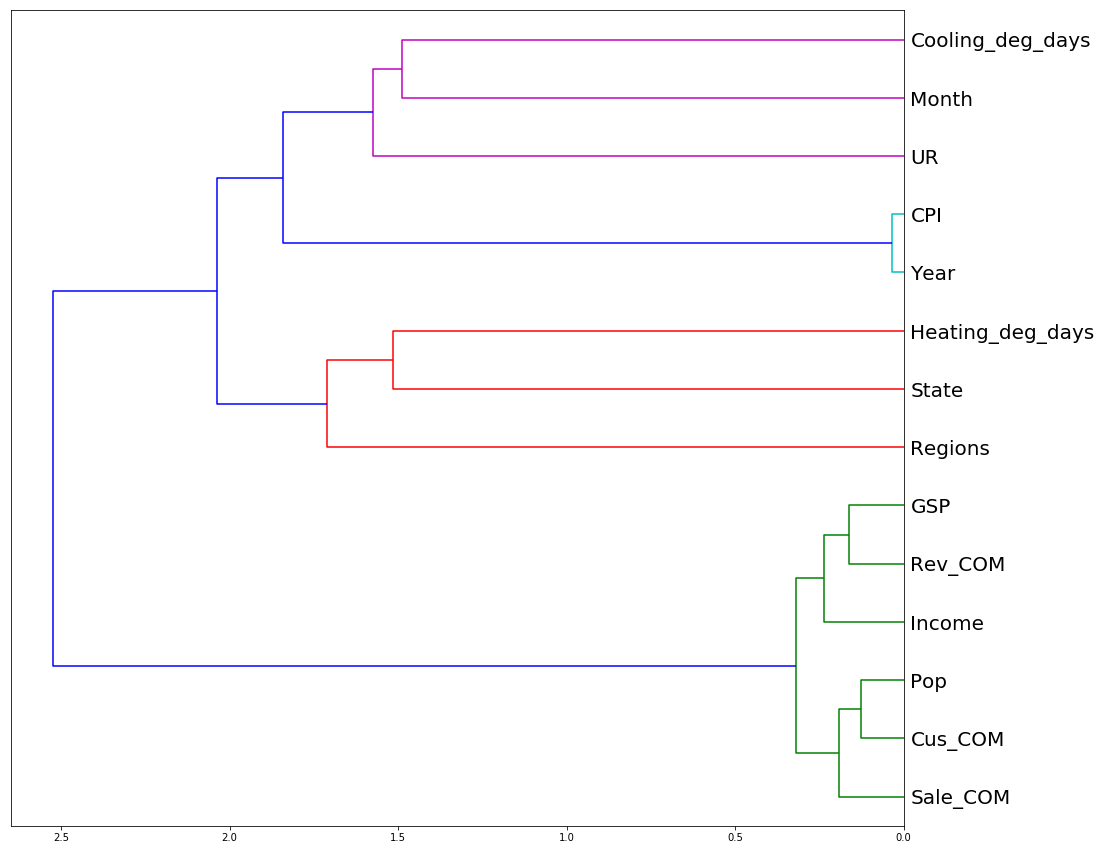

In [56]:
df = combine[['Year', 'Month', 'State', 'Sale_COM','Rev_COM','Cus_COM',
              'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP','CPI', 'Regions']]

from scipy.cluster import hierarchy as hc

# Redundant Feature
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(16,15))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
plt.show()

In [47]:
def get_color(series,cmap=cm.Blues):
    ''' obtain hex color map for each value'''
    vmin = series.min()
    vmax = series.max()
    #normalize item number values to colormap
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    #colormap values = viridis, jet, spectral
    state_colors = [cmap(norm(value)) for value in series.values]
    state_colors = [cm.colors.to_hex(color) for color in state_colors]
    return state_colors

In [48]:
# select data in 2018
data = combine[combine['Year']==2018]
# group by State and obtain average each columns except for the Regions
data = data[['State','Regions','Latitude','Sale_RES_per_cap',
             'Sale_COM_per_cap','Sale_IND_per_cap'
            ]].groupby('State',as_index=False
                      ).agg({'Latitude':'mean','Sale_RES_per_cap':'mean',
             'Sale_COM_per_cap':'mean','Sale_IND_per_cap':'mean',
                             'Regions':'last'
    
})

In [52]:
# another df groupby 'Region'
data2 = combine[combine['Year']==2018].copy()
data2 = data2[['Regions','Latitude','Sale_IND_per_cap']].groupby('Regions',as_index=False).mean()
# assigned industrial color map
ind_colors = get_color(data2['Sale_IND_per_cap'],cm.Paired)
data2['IND_color'] = ind_colors
# merge with the first data df 
data = data.merge(data2.drop('Sale_IND_per_cap',axis=1),on='Regions')

In [53]:
# sort data 
data = data.sort_values(['Latitude_y','Latitude_x'],ascending=True)

In [54]:
# get color map
res_colors = get_color(data['Sale_RES_per_cap'])
ind_colors = data['IND_color'].values
com_colors = get_color(data['Sale_COM_per_cap'],cm.YlGn)

In [58]:
data.Regions.unique()

array(['West South Central ', 'East South Central ', 'South Atlantic ',
       'Mountain ', 'Middle Atlantic ', 'East North Central ',
       'West North Central ', 'Pacific Contiguous ', 'New England '],
      dtype=object)

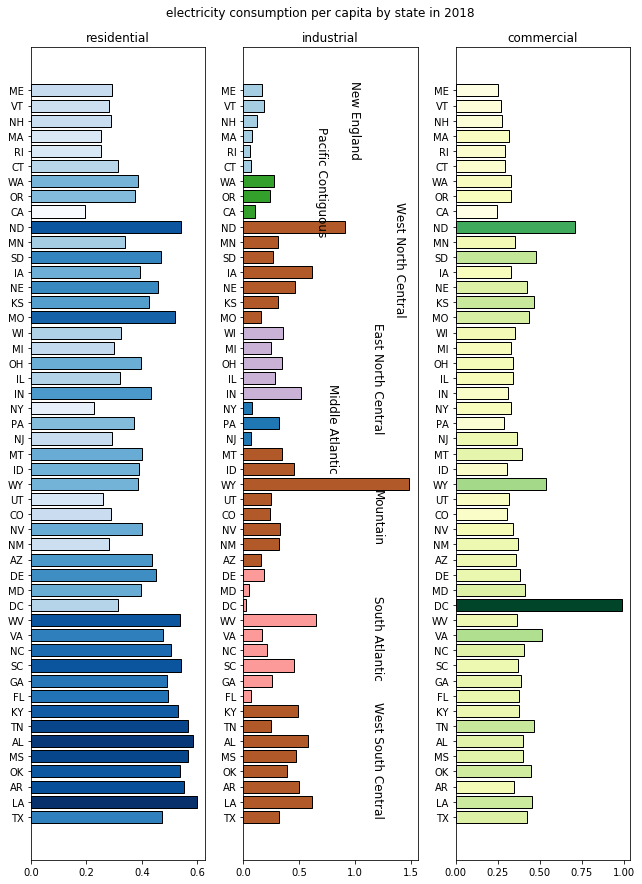

In [85]:
fig, ax = plt.subplots(1,3, figsize=(9,12))
fig.suptitle('electricity consumption per capita by state in 2018',y=1.02)
ax[0].barh(data['State'],data['Sale_RES_per_cap'],color=res_colors,edgecolor='black')
ax[0].set_xlabel('residential',size=12)
ax[0].xaxis.set_label_coords(0.5, 1.02)

ax[2].barh(data['State'],data['Sale_COM_per_cap'],color=com_colors,edgecolor='black')
ax[2].set_xlabel('commercial',size=12)
ax[2].xaxis.set_label_coords(0.5, 1.02)

ax[1].barh(data['State'],data['Sale_IND_per_cap'],color=ind_colors,edgecolor='black')
ax[1].set_xlabel('industrial',size=12)
ax[1].xaxis.set_label_coords(0.5, 1.02)

ax[1].text(1.2, 7, 'West South Central',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(1.2, 14, 'South Atlantic',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(1.2, 21, 'Mountain',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(0.8, 28, 'Middle Atlantic',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(1.2, 32, 'East North Central',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(1.4, 40, 'West North Central',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(0.7, 45, 'Pacific Contiguous',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(1.0, 48, 'New England',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
plt.tight_layout()